In [1]:
## Import required packages
## Base modules
import random
import copy
import time
import numpy as np
import pandas as pd
import numpy as np
import torch as torch
import matplotlib.pyplot as plt

## Pytorch NN modules
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline

## Encoding Modules
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [2]:
# Check local GPU is running, uncomment and run if using a local GPU

torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.get_device_name(0)

# Specify device to use; GPU if found, CPU if not

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

In [3]:
## We'll build a helper function to generate simulated reads.
## Could've gone for specifying probabilities per base,
## but as it's a field test we're keeping it simple.

def random_dna_sequence(length):
    return np.array(list(''.join(random.choice('ACTG') for _ in range(length))))

# Function for generating n x m R matrix,
# where n is the number of reads (total_reads)
# and m is each read's length (read_length).

def create_read_matrix(total_reads,read_length):
    
    read_matrix = []
    
    for i in range(total_reads):
        read_matrix.append(random_dna_sequence(read_length))
        
    return np.vstack(read_matrix)

#Build a function that simultaneously generates unique, desired length k-mers 
##from a previously generated read_matrix and times said k-mer occured.
## Returns both objects ordered by occurence

def create_kmer_matrix(read_matrix,kmer_size):
    
    kmer_matrix = []
    
    for i in range(read_matrix.shape[0]):
        
        for j in range(len(read_matrix[i])-kmer_size+1):
            kmer_matrix.append(read_matrix[i][j:j+kmer_size])
            
    kmer_matrix, counts = np.unique(kmer_matrix,axis=0,return_counts=1)
    #inner index to sort by count occurences
    sort_index = np.argsort(-counts)
    
    return kmer_matrix[sort_index], counts[sort_index]

## function to turn our kmer matrix into a one hot matrix.

def oneshotonehot(kmer_matrix):
    
    # Not yet robust, breaks when single vector is entered;
    # look into reshaping
    
    #Define bases and fit labels to use
    
    vectors = kmer_matrix[0]
    counts = kmer_matrix[1]
    oneshotonehot_matrix = []
    bases = ['A','C','T','G']
    label_encoder = LabelEncoder()
    base_encoder = label_encoder.fit(bases)
    
    for i in range(len(vectors)):
        
        encoded_base_seq = base_encoder.transform(vectors[i])
        reshaped_vector = encoded_base_seq.reshape(-1)
        one_hot_vector = np.eye(len(bases))[reshaped_vector] 
        oneshotonehot_matrix.append(one_hot_vector)
        
    return oneshotonehot_matrix, counts

## One final wrapper function to generate per-sample data on the spot

def generate_kmer_data(total_reads, read_length, kmer_size, number_of_samples):
    
    X = []
    Y = []
    sample_num = [] 
    
    for i in range(number_of_samples):
        
        read_matrix = create_read_matrix(total_reads,read_length)
        kmer_matrix = create_kmer_matrix(read_matrix,kmer_size)
        onehot_matrix = oneshotonehot(kmer_matrix)
        X.extend(onehot_matrix[0])
        Y.extend(onehot_matrix[1])
        sample_num.extend([i+1] * len(onehot_matrix[0]))
        
    return X, Y, sample_num

In [10]:
# We will now generate and load data with our previously created helper functions
## X corresponds to one-hot encoded sequence vectors per kmer sequence
## Y corresponds to the number of times said kmer was counted
## sample corresponds to the sample identifier


## Placeholder batch size
batch_size = 64

X, y, sample = generate_kmer_data(total_reads = 100, read_length = 25, kmer_size = 24, number_of_samples=3)

n_samples = len(X)

X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

# We will now split our generated data into train, validation and test sets.
# With 80%, 10%, 10% of the complete dataset, respectively
## Keeping an additional sample variable with respective identifiers
### This might not be the best way to handle sample tags for future embeddings

X_train, y_train, sample_train = (X[:round(0.8*n_samples)], 
                                  y[:round(0.8*n_samples)], 
                                  sample[:round(0.8*n_samples)])
    
X_val, y_val,sample_val = (X[round(0.8*n_samples):round(0.9*n_samples)],
                           y[round(0.8*n_samples):round(0.9*n_samples)],
                           sample[round(0.8*n_samples):round(0.9*n_samples)])
        
X_test, y_test,sample_test = (X[round(0.9*n_samples):], 
                              y[round(0.9*n_samples):], 
                              sample[round(0.9*n_samples):])

In [11]:
print(X.size())
print(X_train.size())
print(X_test.size())
print(X_val.size())
## Check is train/test/split matches total data
print(X.size(0) == (X_train.size(0) + X_test.size(0) + X_val.size(0)))

torch.Size([600, 24, 4])
torch.Size([480, 24, 4])
torch.Size([60, 24, 4])
torch.Size([60, 24, 4])
True


In [12]:
# We'll now create loader variables for efficient variable management.
from torch.utils.data import DataLoader, TensorDataset

# Possible to do:
## A class may be implemented to automatically turn X, y and sample data to tensors and split from there

train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train),torch.FloatTensor(y_train)),
                          batch_size, shuffle=True)
validation_loader = DataLoader(TensorDataset(torch.FloatTensor(X_val),torch.FloatTensor(y_val)),
                              batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(X_test),torch.FloatTensor(y_test)),
                        batch_size, shuffle=False)

In [15]:

## Define optimizer, RMSprop as per TTLT
## Model was trained for 200 epochs
## Learning rate = 0.001, alpha = 0.99, momentum = 0
### alpha and momentum correspond to pytorch's default value
### for the torch.optim.RMSprop class; 
### therefore, we'll only specify learning rate and epochs.

class biLSTM(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_size, n_layers):
        super(biLSTM, self).__init__()
        
        self.LSTM = nn.LSTM(input_size,
                           hidden_size,
                           n_layers,
                           bidirectional=True)
        
        self.linear = nn.Linear(hidden_size, output_size)
        
        
    def forward(self, x):
        x = x.transpose(0, 1)
        output, hidden_T = self.LSTM(x)
        pred = self.linear(hidden_T[0][-1])
        return pred
    
## As specified by TTLT
input_dim = 4
output_dim = 1
n_layers = 2
hidden_size = 256
        
model_lstm = biLSTM(input_dim, output_dim, hidden_size, n_layers).to(device)

init_lstm_weights = copy.deepcopy(model_lstm.state_dict())

criterion = nn.MSELoss()
optimizer = optim.RMSprop(model_lstm.parameters(), lr=0.001)


X = X.to(device)
y_pred = model_lstm(X)

# Build prediction layer
## MLP
## layers = 2, sizes 150 and 100, respectively
## Activation function = ReLU
        
    
    ## ONCE THAT'S DONE, biLSTMmodel = CLASS().to(device)
        
#bi_lstm = nn.LSTM(input_size=24, hidden_size = 256 , num_layers = 2, bidirectional=True)
#reverse_lstm = nn.LSTM(input_size=24, hidden_size = 256 , num_layers = 2, bidirectional=True)


In [16]:
## Training our model

since = time.time()

n_epoch = 20

train_loss_history = []
valid_loss_history = []


model_lstm.load_state_dict(init_lstm_weights)

print("# Start training #")

for epoch in range(n_epoch):
    
    train_loss = 0
    train_n_iter = 0
    
    # Set model to train mode
    model_lstm.train()
    
    # Iterate over train data
    for x, y in train_loader:  

        
        # Put tensors on device (GPU if available)
        x = x.to(device)
        y = y.to(device)

        # Zero the gradient buffer
        optimizer.zero_grad()
        
        # Forward
        outputs = model_lstm(x)
        # Calculate loss
        loss = criterion(outputs.squeeze(1), y)
        # Backward
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Set model to evaluate mode
    model_lstm.eval()
    
    # Iterate over validation data
    for x, y in validation_loader:  
        
        # Put tensors on device (GPU if available)
        x = x.to(device)
        y = y.to(device)
        
        # Forward
        outputs = model_lstm(x)
        
        loss = criterion(outputs.squeeze(1), y)
        
        # Statistics
        valid_loss += loss.item()
        valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)
    
    print("Epoch {:2d} | Training loss = {:.5f} | Validation loss = {:.5f} "
          .format(epoch+1, (train_loss / train_n_iter), (valid_loss / valid_n_iter)))

time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

# Start training #
Epoch  1 | Training loss = 1.27875 | Validation loss = 0.00642 
Epoch  2 | Training loss = 0.03694 | Validation loss = 0.00012 
Epoch  3 | Training loss = 0.00015 | Validation loss = 0.00033 
Epoch  4 | Training loss = 0.00013 | Validation loss = 0.00007 
Epoch  5 | Training loss = 0.00012 | Validation loss = 0.00006 
Epoch  6 | Training loss = 0.00010 | Validation loss = 0.00015 
Epoch  7 | Training loss = 0.00038 | Validation loss = 0.00133 
Epoch  8 | Training loss = 0.00391 | Validation loss = 0.01029 
Epoch  9 | Training loss = 0.00598 | Validation loss = 0.00215 
Epoch 10 | Training loss = 0.00086 | Validation loss = 0.00014 
Epoch 11 | Training loss = 0.00007 | Validation loss = 0.00005 
Epoch 12 | Training loss = 0.00007 | Validation loss = 0.00017 
Epoch 13 | Training loss = 0.00024 | Validation loss = 0.00072 
Epoch 14 | Training loss = 0.00193 | Validation loss = 0.00480 
Epoch 15 | Training loss = 0.00599 | Validation loss = 0.00444 
Epoch 16 | Training l

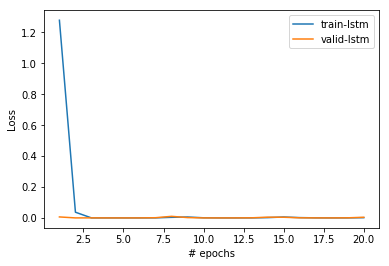

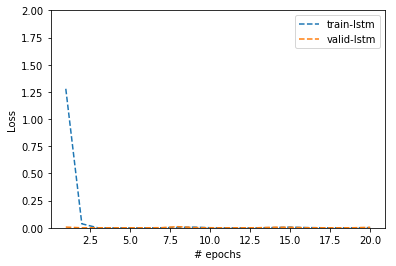

tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>)


In [17]:
lstm_train_loss_history = train_loss_history
lstm_valid_loss_history = valid_loss_history

# Plot training and validation curve
xaxis = range(1, n_epoch + 1)
plt.plot(xaxis, lstm_train_loss_history, label='train-lstm')
plt.plot(xaxis, lstm_valid_loss_history, label='valid-lstm')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plot training and validation curve
xaxis = range(1, n_epoch + 1)

plt.plot(xaxis, lstm_train_loss_history, label='train-lstm', linestyle='--')
plt.plot(xaxis, lstm_valid_loss_history, label='valid-lstm', linestyle='--')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim([0,2])
plt.show()

# Put data on gpu
X_test = X_test.to(device)
y_test = y_test.to(device)

ypred_lstm = model_lstm(X_test).squeeze(1)
loss_test_lstm = criterion(ypred_lstm, y_test)

print(loss_test_lstm)